In [ ]:
# Install the roboflow package
!pip install roboflow

# Import the Roboflow class
from roboflow import Roboflow

# Initialize the Roboflow object with your API key
rf = Roboflow(api_key="zu9rrWGVjltjDOFNbpjX")

# Access the project within the workspace
project = rf.workspace("shirts").project("id-card-text-rjde9")

# Access a specific version of the project
version = project.version(1)

# Download the dataset in COCO format
dataset = version.download("coco")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.8
    Uninstalling idna-3.8:
      Successfully uninstalled idna-3.8
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ID-CARD-TEXT-1 in coco:: 100%|██████████| 33/33 [00:00<00:00, 2545.74it/s]


In [ ]:
import cv2
import numpy as np

def preprocess_image(image_path, target_size=(512, 512)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = (image / 255.0 * 255).astype(np.uint8)  # Normalize pixel values and convert to uint8
    return image

# Load the COCO annotations
with open(os.path.join(dataset.location, 'annotations', '/content/ID-CARD-TEXT-1/train/_annotations.coco.json')) as f:
    annotations = json.load(f)

# Example usage
image_dir = os.path.join(dataset.location, '/content/ID-CARD-TEXT-1/train')
image_paths = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
preprocessed_images = [preprocess_image(img_path) for img_path in image_paths]

In [ ]:
import cv2
import numpy as np

# Load the pre-trained EAST model
net = cv2.dnn.readNet('frozen_east_text_detection.pb')

def detect_text(image):
    orig = image.copy()
    (H, W) = image.shape[:2]

    # Define the output layer names for the EAST detector model
    layer_names = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ]

    # Ensure the image is in uint8 format
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Construct a blob from the image and then perform a forward pass of the model
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layer_names)

    # Decode the predictions
    (rects, confidences) = decode_predictions(scores, geometry)
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    return boxes

# Example usage
image = preprocess_image(image_paths[0])
boxes = detect_text(image)
print(boxes)

NameError: name 'decode_predictions' is not defined

In [ ]:
import cv2
import numpy as np
import os
import json
from roboflow import Roboflow

def preprocess_image(image_path, target_size=(512, 512)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = (image / 255.0 * 255).astype(np.uint8)  # Normalize pixel values and convert to uint8
    return image

def decode_predictions(scores, geometry):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    return (rects, confidences)

def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2 if probs is None else probs

    idxs = np.argsort(idxs)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")

# Load the pre-trained EAST model
net = cv2.dnn.readNet('frozen_east_text_detection.pb')

def detect_text(image):
    orig = image.copy()
    (H, W) = image.shape[:2]

    # Define the output layer names for the EAST detector model
    layer_names = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ]

    # Ensure the image is in uint8 format
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Construct a blob from the image and then perform a forward pass of the model
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layer_names)

    # Decode the predictions
    (rects, confidences) = decode_predictions(scores, geometry)
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    return boxes

# Load the COCO annotations
with open(os.path.join(dataset.location, 'annotations', '/content/ID-CARD-TEXT-1/train/_annotations.coco.json')) as f:
    annotations = json.load(f)

# Example usage
image_dir = os.path.join(dataset.location, '/content/ID-CARD-TEXT-1/train')
image_paths = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
image = preprocess_image(image_paths[0])
boxes = detect_text(image)
print(boxes)

[[286 130 330 156]
 [248 236 294 264]
 [268  39 320  64]
 [158 326 201 344]
 [224  87 259 101]
 [203 407 264 433]
 [245 129 280 154]
 [169 413 213 437]
 [406 472 454 489]
 [300 237 333 263]
 [282 177 349 213]
 [172  84 207  98]
 [203 470 236 493]
 [319 403 340 429]
 [ 65 446 114 478]
 [288 281 349 311]
 [164 242 247 264]
 [132  32 259  73]
 [157 219 196 236]
 [162 126 250 154]
 [365 480 399 495]
 [161 390 203 409]
 [379  42 408  65]
 [308 461 341 485]
 [324  41 375  65]
 [162 453 189 471]
 [217 347 262 372]
 [281 407 313 431]
 [271 383 305 403]
 [209 322 252 341]
 [166 473 207 497]
 [313 382 338 401]
 [140  83 169  97]
 [194 222 227 237]
 [203 451 228 468]
 [270 439 307 459]
 [312 440 340 460]
 [282 464 315 486]
 [207 389 247 408]
 [264 325 286 342]
 [152 104 197 123]
 [397 398 430 450]
 [ 77  65  97 114]
 [407   3 446  17]]


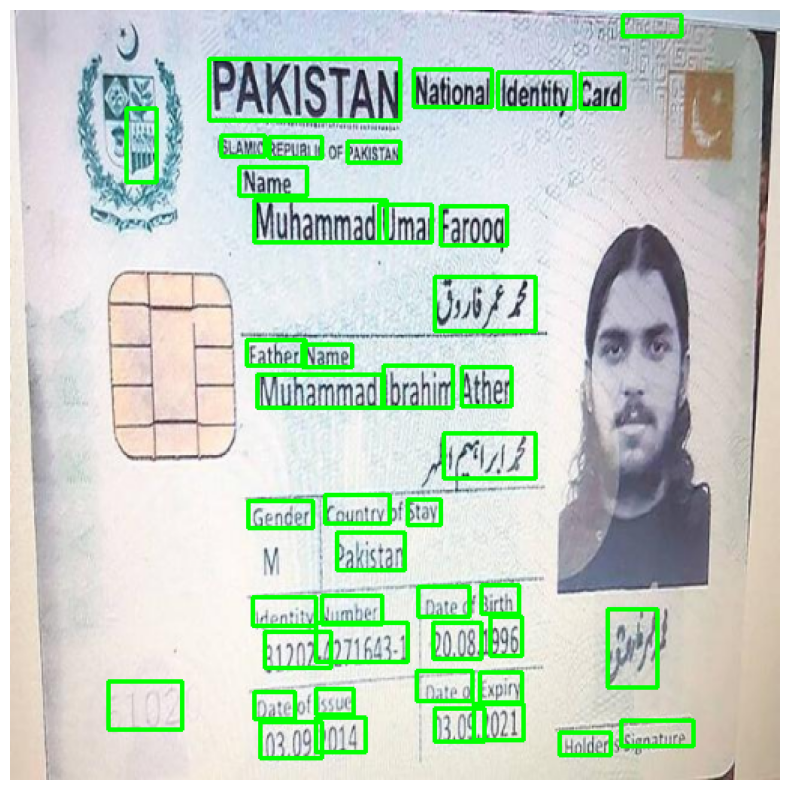

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_boxes(image, boxes):
    for (startX, startY, endX, endY) in boxes:
        cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
    return image

# Example usage
image = preprocess_image(image_paths[0])
boxes = detect_text(image)
image_with_boxes = draw_boxes(image.copy(), boxes)

# Convert BGR image to RGB for displaying with matplotlib
image_with_boxes_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(image_with_boxes_rgb)
plt.axis('off')
plt.show()

In [ ]:
!sudo apt-get install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,483 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

Detected text: barn

Detected text: Ihrahir

Detected text: National

Detected text: Gender

Detected text: 
Detected text: Flare

Detected text: Uma

Detected text: bt Vd

Detected text: fe eal

Detected text: Athor

Detected text: ub 2

Detected text: DEDIA

Detected text: me

Detected text: dG)

Detected text: Et

Detected text: 
Detected text: Ninammad

Detected text: PAKISTAN

Detected text: Father

Detected text: Muhammad!

Detected text: ‘Molden

Detected text: | dontity

Detected text: Par

Detected text: 001

Detected text: Adentity

Detected text: ny atel

Detected text: Dalictan

Detected text: D118,

Detected text: ate 4

Detected text:  suintry|

Detected text: 2.19)

Detected text: birth |

Detected text: Ri A Mir’

Detected text: Name

Detected text: a

Detected text: Fate a

Detected text: Expiry

Detected text: 3 4

Detected text: Lumber!

Detected text: tay

Detected text: Name

Detected text: NH

Detected text: ft

Detected 

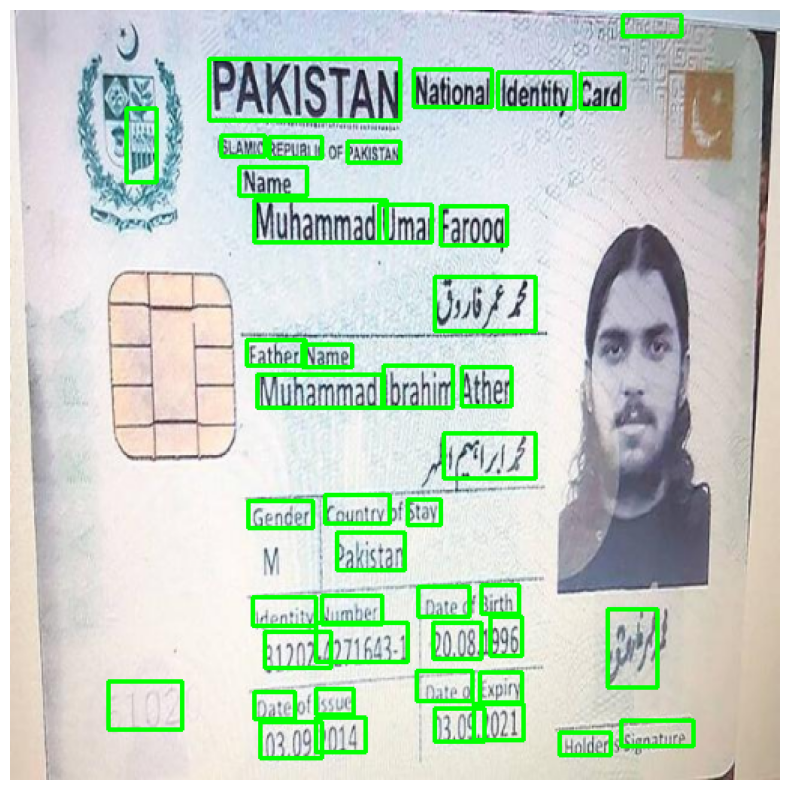

In [ ]:
import cv2
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import pytesseract
from roboflow import Roboflow

def preprocess_image(image_path, target_size=(512, 512)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = (image / 255.0 * 255).astype(np.uint8)  # Normalize pixel values and convert to uint8
    return image

def decode_predictions(scores, geometry):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    return (rects, confidences)

def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2 if probs is None else probs

    idxs = np.argsort(idxs)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")

# Load the pre-trained EAST model
net = cv2.dnn.readNet('frozen_east_text_detection.pb')

def detect_text(image):
    orig = image.copy()
    (H, W) = image.shape[:2]

    # Define the output layer names for the EAST detector model
    layer_names = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ]

    # Ensure the image is in uint8 format
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Construct a blob from the image and then perform a forward pass of the model
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layer_names)

    # Decode the predictions
    (rects, confidences) = decode_predictions(scores, geometry)
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    return boxes

def draw_boxes_and_extract_text(image, boxes):
    detected_texts = []
    for (startX, startY, endX, endY) in boxes:
        cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
        roi = image[startY:endY, startX:endX]
        text = pytesseract.image_to_string(roi, config='--psm 6')
        detected_texts.append(text)
        print(f"Detected text: {text}")
    return image, detected_texts

# Load the COCO annotations
with open(os.path.join(dataset.location, 'annotations', '/content/ID-CARD-TEXT-1/train/_annotations.coco.json')) as f:
    annotations = json.load(f)

# Example usage
image_dir = os.path.join(dataset.location, '/content/ID-CARD-TEXT-1/train')
image_paths = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
image = preprocess_image(image_paths[0])
boxes = detect_text(image)
image_with_boxes, detected_texts = draw_boxes_and_extract_text(image.copy(), boxes)

# Convert BGR image to RGB for displaying with matplotlib
image_with_boxes_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(image_with_boxes_rgb)
plt.axis('off')
plt.show()

In [ ]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 kB 15.8 MB/s eta 0:00:00


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possibl

Detected text: ['Farood ']
Detected text: ['Ibrahi']
Detected text: ['National']
Detected text: ['Gengem']
Detected text: ['H4KISIa s']
Detected text: []
Detected text: []
Detected text: []
Detected text: []
Detected text: ['Athen']
Detected text: ['Viif_']
Detected text: ['Earu']
Detected text: ['DOI']
Detected text: ['996']
Detected text: []
Detected text: []
Detected text: ['Mhammad']
Detected text: ['PAKISTAN']
Detected text: ['Fatherd']
Detected text: ['Muhammadl']
Detected text: ['Moller']
Detected text: []
Detected text: ['Card']
Detected text: ['12021']
Detected text: ['Identitv']
Detected text: []
Detected text: ["'akistal"]
Detected text: ['20,081']
Detected text: ['Dltel']
Detected text: []
Detected text: ['03 IIL']
Detected text: []
Detected text: []
Detected text: ['Hame']
Detected text: []
Detected text: []
Detected text: []
Detected text: []
Detected text: []
Detected text: []
Detected text: ['Name']
Detected text: []
Detected text: []
Detected text: []


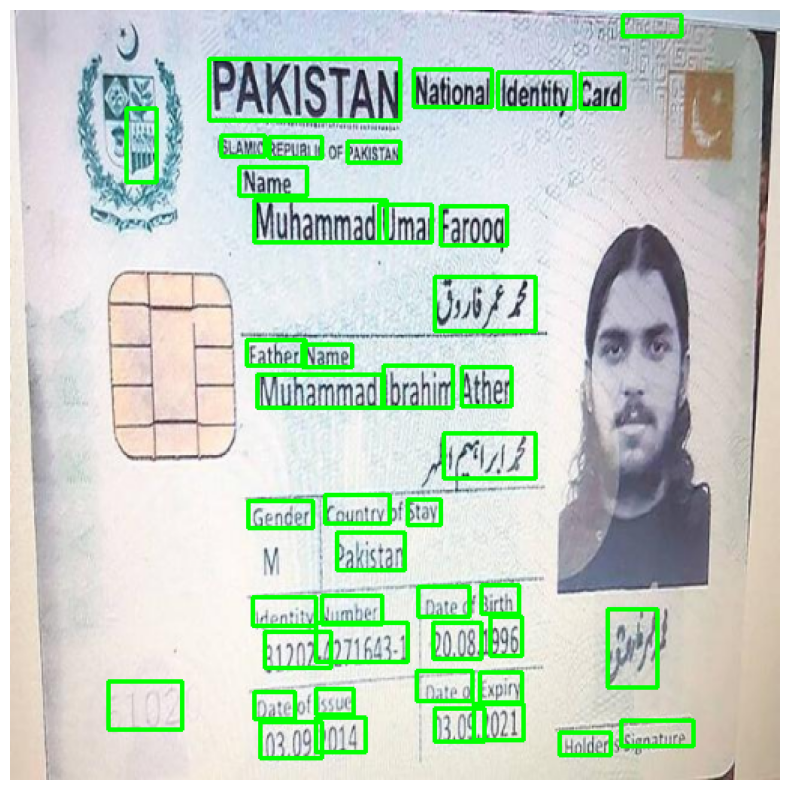

In [ ]:
import cv2
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import easyocr
from roboflow import Roboflow

def preprocess_image(image_path, target_size=(512, 512)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = (image / 255.0 * 255).astype(np.uint8)  # Normalize pixel values and convert to uint8
    return image

def decode_predictions(scores, geometry):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    return (rects, confidences)

def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2 if probs is None else probs

    idxs = np.argsort(idxs)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")

# Load the pre-trained EAST model
net = cv2.dnn.readNet('frozen_east_text_detection.pb')

def detect_text(image):
    orig = image.copy()
    (H, W) = image.shape[:2]

    # Define the output layer names for the EAST detector model
    layer_names = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ]

    # Ensure the image is in uint8 format
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Construct a blob from the image and then perform a forward pass of the model
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layer_names)

    # Decode the predictions
    (rects, confidences) = decode_predictions(scores, geometry)
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    return boxes

def draw_boxes_and_extract_text(image, boxes):
    reader = easyocr.Reader(['en'])  # Initialize EasyOCR reader
    detected_texts = []
    for (startX, startY, endX, endY) in boxes:
        cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
        roi = image[startY:endY, startX:endX]
        text = reader.readtext(roi, detail=0)
        detected_texts.append(text)
        print(f"Detected text: {text}")
    return image, detected_texts

# Load the COCO annotations
with open(os.path.join(dataset.location, 'annotations', '/content/ID-CARD-TEXT-1/train/_annotations.coco.json')) as f:
    annotations = json.load(f)

# Example usage
image_dir = os.path.join(dataset.location, '/content/ID-CARD-TEXT-1/train')
image_paths = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
image = preprocess_image(image_paths[0])
boxes = detect_text(image)
image_with_boxes, detected_texts = draw_boxes_and_extract_text(image.copy(), boxes)

# Convert BGR image to RGB for displaying with matplotlib
image_with_boxes_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(image_with_boxes_rgb)
plt.axis('off')
plt.show()

Image paths:
/content/ID-CARD-TEXT-1/train/21_jpg.rf.046198b19c2e3e3b428fa36c35a1d19a.jpg
/content/ID-CARD-TEXT-1/train/6_jpg.rf.01f57b77a7ad88942a0275a3e1afa2e3.jpg
/content/ID-CARD-TEXT-1/train/20_jpg.rf.181f45081523a65a2c95771a1b5952cc.jpg
/content/ID-CARD-TEXT-1/train/25_jpg.rf.3cddccc2a100e61eaaa84381997ffbb8.jpg
/content/ID-CARD-TEXT-1/train/24_jpg.rf.3b023132bb262453e86d65c3e554af71.jpg
/content/ID-CARD-TEXT-1/train/14_jpg.rf.6aa03984b2a8dd742346365a9e4746c6.jpg
/content/ID-CARD-TEXT-1/train/7_jpg.rf.38693463b4090cd92430a8588d1785b6.jpg
/content/ID-CARD-TEXT-1/train/4_jpg.rf.822577fce77fc9e804e452deb38a4b3e.jpg
/content/ID-CARD-TEXT-1/train/22_jpg.rf.9a8fd890b850e05b84b01dcd8c8d54a5.jpg
/content/ID-CARD-TEXT-1/train/2_jpg.rf.f3dfebe8dfca41f3f5b0da8de7c335db.jpg
/content/ID-CARD-TEXT-1/train/13_jpg.rf.1f5cab1730c29fc8c5b0eff071586c64.jpg
/content/ID-CARD-TEXT-1/train/15_jpg.rf.870d4ec8111b0a4a7e20455cc7e9c909.jpg
/content/ID-CARD-TEXT-1/train/16_jpg.rf.ba1bd8fbfdcea290b1a2e8f04f5

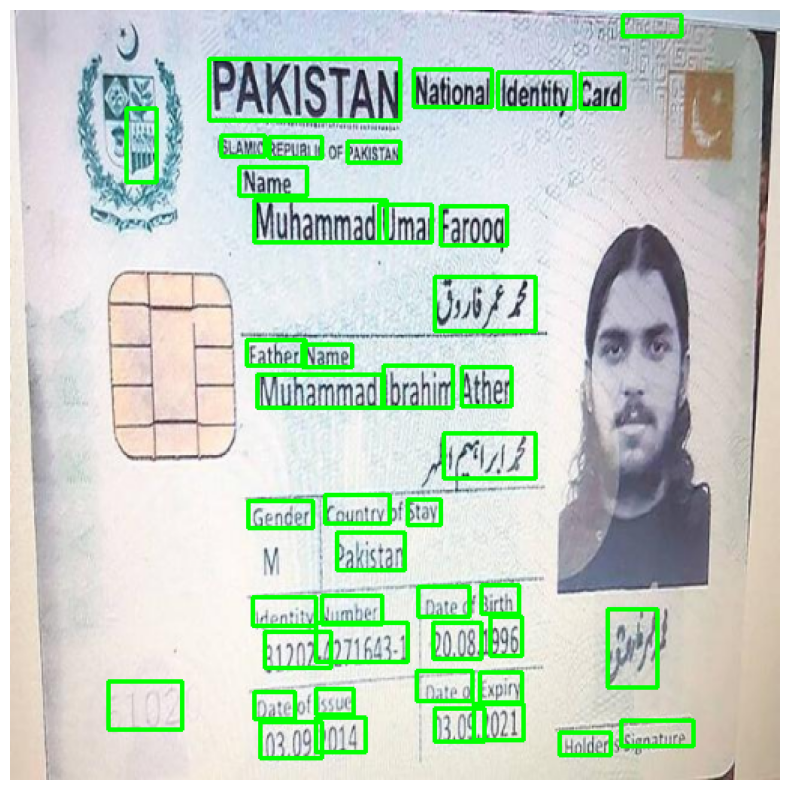

In [ ]:
import cv2
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import pytesseract
from roboflow import Roboflow

def preprocess_image(image_path, target_size=(512, 512)):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    image = cv2.resize(image, target_size)
    image = (image / 255.0 * 255).astype(np.uint8)  # Normalize pixel values and convert to uint8
    return image

def decode_predictions(scores, geometry):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    return (rects, confidences)

def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2 if probs is None else probs

    idxs = np.argsort(idxs)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")

# Load the pre-trained EAST model
net = cv2.dnn.readNet('frozen_east_text_detection.pb')

def detect_text(image):
    orig = image.copy()
    (H, W) = image.shape[:2]

    # Define the output layer names for the EAST detector model
    layer_names = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ]

    # Ensure the image is in uint8 format
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Construct a blob from the image and then perform a forward pass of the model
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layer_names)

    # Decode the predictions
    (rects, confidences) = decode_predictions(scores, geometry)
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    return boxes

def draw_boxes_and_extract_text(image, boxes):
    detected_texts = []
    for (startX, startY, endX, endY) in boxes:
        cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
        roi = image[startY:endY, startX:endX]
        text = pytesseract.image_to_string(roi)
        detected_texts.append(text)
        print(f"Detected text: {text}")
    return image, detected_texts

# Load the COCO annotations
dataset_location = '/content/ID-CARD-TEXT-1/train'  # Update this path to your dataset location
with open(os.path.join(dataset_location, '_annotations.coco.json')) as f:
    annotations = json.load(f)

# Extract image paths from the annotations
image_dir = dataset_location
image_paths = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]

# Print image paths for debugging
print("Image paths:")
for path in image_paths:
    print(path)

# Example usage
image = preprocess_image(image_paths[0])
boxes = detect_text(image)
image_with_boxes, detected_texts = draw_boxes_and_extract_text(image.copy(), boxes)

# Convert BGR image to RGB for displaying with matplotlib
image_with_boxes_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(image_with_boxes_rgb)
plt.axis('off')
plt.show()